In [1]:
from bs4 import BeautifulSoup  # For HTML parsing
import re  # Regular expressions
from time import sleep  # To prevent overwhelming the server between connections
import requests
import pickle
from pymongo import MongoClient, errors
import numpy as np

In [2]:
try:
    client = MongoClient()
    print ("Connected successfully!!!")
except pymongo.errors.ConnectionFailure:
    print ("Could not connect to MongoDB: %s" % e)
client

Connected successfully!!!


MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [3]:
db = client.jobs_database

In [4]:
coll = db.job_collection_all

In [5]:
# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
for job in coll.find():
    print(job['title'])
    break

Echoing Green - Jobs: Fundraising Intern - Apply online


In [7]:
desc = []
for job in coll.find():
    desc.append(job['description'])

In [1]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(analyzer='word',
                                  ngram_range=(1, 8), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
count_vectorizer.fit_transform(desc)

NameError: name 'CountVectorizer' is not defined

In [9]:
ng_vecs = count_vectorizer.transform(desc).transpose()
ng_vecs.shape

(1327288, 6641)

In [10]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(ng_vecs)

In [11]:
for item in count_vectorizer.vocabulary_.items():
    print(item)
    break

('graduation instruction news events calendars personal info', 505290)


In [12]:
count = 0
for item in corpus:
    count += 1
count

6641

In [14]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

NameError: name 'count_vectorizer' is not defined

## Topic modeling

#### LDA
At this point we can simply plow ahead in creating an LDA model. It requires our corpus of word counts, mapping of row ids to words, and the number of topics (3).

In [28]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus, id2word=id2word, num_topics=5, passes=10)

In [29]:
lda.print_topics(num_words=20, num_topics=5)

[(0,
  '0.009*linguist + 0.007*language + 0.007*data + 0.006*earnest + 0.006*self + 0.005*research + 0.005*job + 0.004*service + 0.004*caesars + 0.004*hart + 0.004*linguistics + 0.004*careers + 0.003*site + 0.003*career + 0.003*ntid + 0.003*sign + 0.003*st + 0.003*nmlsconsumeraccess + 0.003*nmls + 0.003*list'),
 (1,
  '0.039*loading + 0.015*wait + 0.012*content + 0.010*page + 0.002*requirements + 0.002*resume + 0.002*navy + 0.002*experience + 0.002*aperture + 0.002*documents + 0.002*data + 0.002*youll + 0.002*usajobs + 0.002*gov + 0.002*information + 0.002*application + 0.002*scientist + 0.002*www + 0.002*experienced + 0.001*apply'),
 (2,
  '0.011*data + 0.008*glassdoor + 0.006*job + 0.006*roche + 0.005*analysis + 0.005*memorial + 0.004*sequencing + 0.004*analytics + 0.003*machine + 0.003*healthcare + 0.003*santa + 0.003*design + 0.003*analytical + 0.003*share + 0.003*experience + 0.003*learning + 0.003*mining + 0.003*work + 0.003*search + 0.003*software'),
 (3,
  '0.013*ihs + 0.010*mi

## TFIDF
to include weights in words based on their frequency.

this is directly proportional to term count within documents

inverse proportional to term count over all docs

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
# Create a CountVectorizer for parsing/counting words
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                  ngram_range=(1,1), stop_words=stop_words,
                                  token_pattern='\\b[a-z][a-z]+\\b')

In [12]:
tfidf_vectorizer.fit(desc)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'ar...yours', 'yourself', 'yourselves', 'data', 'scientist', 'new', 'york', 'science', 'job', 'work', 's'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='\\b[a-z][a-z]+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [13]:
ng_vecs = tfidf_vectorizer.transform(desc).transpose()
ng_vecs.shape

(18263, 6641)

In [14]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(ng_vecs)

In [15]:
id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())

#### ------------------------------------------------------------

In [16]:
# Create a TFIDF transformer from our word counts (equivalent to "fit" in sklearn)
tfidf = models.TfidfModel(corpus)

In [17]:
# Create a TFIDF vector for all documents from the original corpus ("transform" in sklearn)
tfidf_corpus = tfidf[corpus]

In [71]:
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary.from_corpus(tfidf_corpus,
                                    id2word=dict((id, word) for word, id in tfidf_vectorizer.vocabulary_.items()))

In [104]:
# Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics
# num_topics is the number of dimensions to reduce to after the SVD
# Analagous to "fit" in sklearn, it primes an LSI space
lsi = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=300)

In [105]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[corpus]

In [67]:
# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]

In [68]:
# Create an index transformer that calculates similarity based on our space
index = similarities.MatrixSimilarity(doc_vecs)

In [69]:
len(index[doc_vecs[1]])

6641

In [70]:
# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[doc_vecs[1]]), key=lambda item: -item[1])
sims[:20]

[(1, 1.0),
 (20, 1.0),
 (409, 0.99999994),
 (413, 0.99999994),
 (769, 0.9999997),
 (427, 0.99999934),
 (697, 0.99999934),
 (597, 0.99999571),
 (2229, 0.99999571),
 (2270, 0.99999571),
 (2285, 0.99999571),
 (2349, 0.99999571),
 (2439, 0.99999571),
 (2446, 0.99999571),
 (2635, 0.99999571),
 (2714, 0.99999571),
 (2790, 0.99999571),
 (3077, 0.99999571),
 (3106, 0.99999571),
 (3165, 0.99999571)]

In [28]:
from collections import Counter
import pandas as pd

In [31]:
stop_words = ["a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves", "data", "scientist", "new", "york", "science", "job", "work", "s", "jobs", "000"]

In [32]:
def word_frequency(job, stop_words):
    freqs = {}
    counts = Counter(job.split())
    for k, v in counts.items():
        if v > 2 and k not in stop_words:
            freqs[k] = v/len(job.split())
    print(freqs)
    df = pd.DataFrame([freqs]).T
    return df

In [33]:
df = word_frequency(' '.join([desc[44], desc[1]]), stop_words)

{'115': 0.003092783505154639, '646': 0.003092783505154639, 'predictive': 0.007216494845360825, '150': 0.003092783505154639, 'address': 0.004123711340206186, 'models': 0.003092783505154639, 'contact': 0.003092783505154639, 'startup': 0.003092783505154639, 'technology': 0.003092783505154639, 'techniques': 0.006185567010309278, 'team': 0.006185567010309278, 'role': 0.004123711340206186, 'office': 0.003092783505154639, 'recruiter': 0.003092783505154639, 'use': 0.003092783505154639, 'apply': 0.006185567010309278, 'decisions': 0.004123711340206186, 'relationships': 0.003092783505154639, 'build': 0.003092783505154639, 'blog': 0.004123711340206186, 'statistical': 0.003092783505154639, 'learning': 0.003092783505154639, 'follow': 0.004123711340206186, 'rapidly': 0.003092783505154639, 'experience': 0.005154639175257732, 'distinctive': 0.003092783505154639, 'analytics': 0.005154639175257732, 'modeling': 0.007216494845360825, 'ny': 0.006185567010309278, 'challenges': 0.003092783505154639, 'city': 0

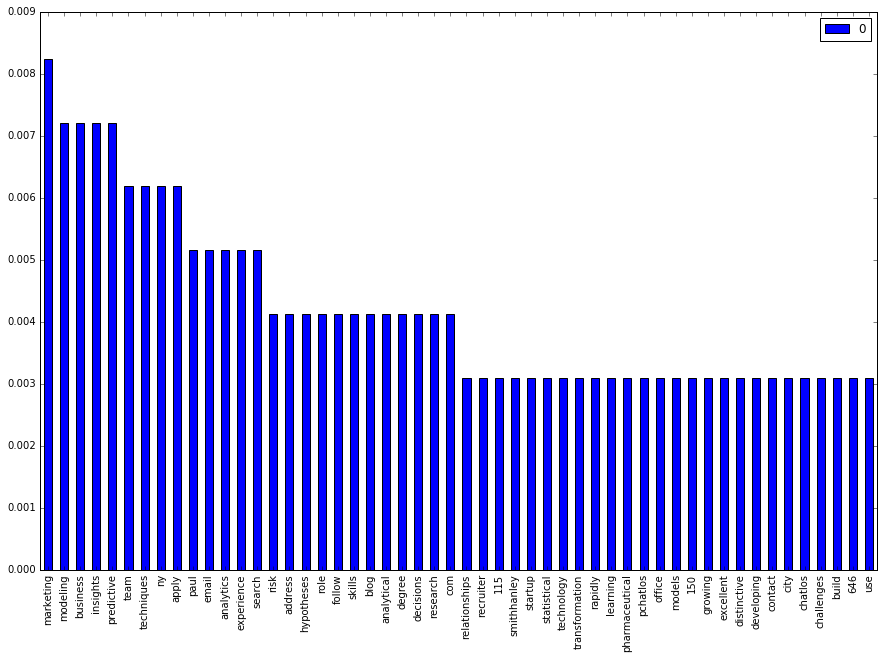

In [34]:
%matplotlib inline

df.sort_values(by = 0, ascending=False).plot(kind='bar', figsize=(15, 10))

In [144]:
desc[1]

'data scientist for startup   averity view all jobs visit our website data scientist for startup averity   new york  ny we are a rapidly growing startup in the marketing tech world looking for a data scientist to join our newly created data science team  what s the job we can promise you that your work with us will never be boring  as a data scientist in our data science team  you will be using scientific techniques  such as machine learning  predictive modeling  and data mining to analyze user behavior  you will report your finding to management and ultimately  your work will impact our company s future success who are we we are a marketing tech start up based in new york city  we are backed by major venture firms and rapidly growing  with office across the country  our newly created data science team works out of our new york city office located in the flatiron area of manhattan compensation 100 000    135 000full benefitswhat skills do you needmachine learning techniquesknowledge of

In [42]:
desc[692]

'careers   huawei global  change  us jobs canada jobs global jobs sdn   machine learning intern location  santa clara  ca  r d  req    6501   of openings  1 the opportunity  as a company  we are committed to creating maximum value for telecom operators  enterprises and consumers by providing competitive solutions and services  our products and solutions have been deployed in over 140 countries  serving more than one third of the worlds population  huawei s vision is to enrich life through communication  description sdn   machine learning intern futurewei technologies   huawei usa is starting a new business group focused on enterprise solutions  futurewei technologies is looking for exceptional people with solid and demonstrated expertise in various areas to help create and execute our technical creations and innovations that will ensure our company in a leadership role in this very important opportunity space  this is an incredible opportunity to enable you to contribute to shape the s

In [ ]:
## text_blobs = ' '.join([desc[1], desc[229], desc[10], desc[534]])

In [106]:
len(text_blobs)

10480

In [108]:
count = 0
for j in coll.find():
    print(count, j['url'])
    count += 1
    if count > 50:
        break

0 http://www.indeed.com/rc/clk?jk=3a736307116dd50a&fccid=d724b507863bb5b1
1 http://www.indeed.com/rc/clk?jk=82385b59d57c2166&fccid=39407476605079e0
2 http://www.indeed.com/rc/clk?jk=ca5a2c136eaccc1d&fccid=181ae1a6390e21b5
3 http://www.indeed.com/rc/clk?jk=4121a8a5ec79dbfc&fccid=f65aedcd2de292bf
4 http://www.indeed.com/rc/clk?jk=cde086027099b03b&fccid=4e9c4ad9d973d979
5 http://www.indeed.com/rc/clk?jk=ba072e94de1a5dba&fccid=e127f4594cdf24f4
6 http://www.indeed.com/rc/clk?jk=762dcebab0a10de3&fccid=61bb2b2cdd4507ae
7 http://www.indeed.com/rc/clk?jk=38761288da163e7f&fccid=ad9a355de43f962a
8 http://www.indeed.com/rc/clk?jk=1be48ee4132670bf&fccid=be3b11aa573faee7
9 http://www.indeed.com/rc/clk?jk=c9961fe7f2f0bdcc&fccid=b445cea762cc7d0d
10 http://www.indeed.com/rc/clk?jk=ad9f0dbd2739c2d8&fccid=e032d49a262c01c8
11 http://www.indeed.com/rc/clk?jk=251ce788e98a5403&fccid=9b4cf72eb101bebf
12 http://www.indeed.com/rc/clk?jk=eba548b4f6efc67b&fccid=c9760fb6d1cce259
13 http://www.indeed.com/rc/clk?jk=

In [99]:
import webarticle2text

In [219]:
len(new_list)

910

In [213]:
# Create some test text blobs to compare pairwise
#text_blobs = ['startup']
# Get matrix of counts
test_vecs = tfidf_vectorizer.transform(text_blobs).transpose()
# Convert to gensim corpus
test_corpus = matutils.Sparse2Corpus(test_vecs)
# TFIDF transformation
test_tfidf = tfidf[test_corpus]
# LSI transformation
test_lsi = lsi[test_tfidf]

In [214]:
# Index our test text blobs
test_index = similarities.MatrixSimilarity(test_lsi)

In [215]:
text_blobs[1][:70]

'data scientist   well funded startup job in new york  ny   jobspring p'

In [216]:
# For each test text blob that we're looking at
for i, sims in enumerate(test_index):
    # We get a list of similarities to all indexed text blobs
    # Print the text blob we're currently examining
    print ("Similarities to {}:".format(text_blobs[i][:70]))
    # Print the similarities of the current blob to all others with labels
    sims_with_labels = [(score, text_blobs[j][:70]) for j, score in enumerate(sims)]
    # Sort the results by decreasing similarity and print them out
    sorted_sims_with_labels = sorted(sims_with_labels, reverse=True)
    print (sorted_sims_with_labels)
    print ('\n')

Similarities to data scientist for startup   averity view all jobs visit our website d:
[(0.99999976, 'data scientist for startup   averity view all jobs visit our website d'), (0.794743, 'senior data scientist  client facing    averity view all jobs visit ou'), (0.18097329, 'bluecore   jobs  data scientist   apply online all jobs  data scientis'), (0.082620971, 'data scientist   well funded startup job in new york  ny   jobspring p')]


Similarities to data scientist   well funded startup job in new york  ny   jobspring p:
[(0.99999958, 'data scientist   well funded startup job in new york  ny   jobspring p'), (0.082620971, 'data scientist for startup   averity view all jobs visit our website d'), (0.056406535, 'senior data scientist  client facing    averity view all jobs visit ou'), (-0.016373284, 'bluecore   jobs  data scientist   apply online all jobs  data scientis')]


Similarities to bluecore   jobs  data scientist   apply online all jobs  data scientis:
[(1.0, 'bluecore   jobs

In [59]:
import logging
import os
import gensim

MODELS_DIR = "./"
# write out coordinates to file
fcoords = open(os.path.join(MODELS_DIR, "coords.csv"), 'w')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()

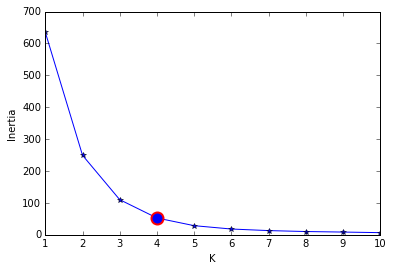

In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

MODELS_DIR = "./"
MAX_K = 10

X = np.loadtxt(os.path.join(MODELS_DIR, "coords.csv"), delimiter="\t")
ks = range(1, MAX_K + 1)

inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)
for k in ks:
    kmeans = KMeans(k).fit(X)
    inertias[k - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

elbow = np.argmin(diff3[3:]) + 3

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

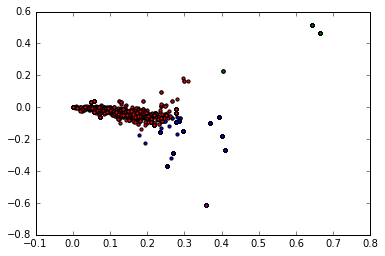

In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

MODELS_DIR = "./"
NUM_TOPICS = 4

X = np.loadtxt(os.path.join(MODELS_DIR, "coords.csv"), delimiter="\t")
kmeans = KMeans(NUM_TOPICS).fit(X)
y = kmeans.labels_

colors = ["b", "g", "r", "m", "c"]
for i in range(X.shape[0]):
    plt.scatter(X[i][0], X[i][1], c=colors[y[i]], s=10, )    
plt.show()

In [72]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(tfidf_corpus, id2word=dictionary, num_topics=4, passes=10)
lda.print_topics(4)

[(0,
  '0.013*mars + 0.008*password + 0.004*chocolate + 0.004*cacao + 0.004*accounts + 0.003*enter + 0.003*functionality + 0.003*dod + 0.003*start + 0.002*reset'),
 (1,
  '0.014*loading + 0.011*ihs + 0.010*glassdoor + 0.009*linguist + 0.006*splunk + 0.006*earnest + 0.005*password + 0.004*language + 0.004*wait + 0.004*linguistics'),
 (2,
  '0.012*roche + 0.009*self + 0.008*sequencing + 0.006*caesars + 0.006*peoplesoft + 0.006*hart + 0.005*santa + 0.005*oracle + 0.004*alto + 0.004*palo'),
 (3,
  '0.012*memorial + 0.011*michigan + 0.009*cardiovascular + 0.006*arbor + 0.006*ann + 0.005*investigator + 0.005*charts + 0.005*temporary + 0.004*university + 0.004*atherosclerosis')]

In [97]:

for line in lda.print_topics(4):
    print(line[1])

0.013*mars + 0.008*password + 0.004*chocolate + 0.004*cacao + 0.004*accounts + 0.003*enter + 0.003*functionality + 0.003*dod + 0.003*start + 0.002*reset
0.014*loading + 0.011*ihs + 0.010*glassdoor + 0.009*linguist + 0.006*splunk + 0.006*earnest + 0.005*password + 0.004*language + 0.004*wait + 0.004*linguistics
0.012*roche + 0.009*self + 0.008*sequencing + 0.006*caesars + 0.006*peoplesoft + 0.006*hart + 0.005*santa + 0.005*oracle + 0.004*alto + 0.004*palo
0.012*memorial + 0.011*michigan + 0.009*cardiovascular + 0.006*arbor + 0.006*ann + 0.005*investigator + 0.005*charts + 0.005*temporary + 0.004*university + 0.004*atherosclerosis


In [102]:
words

['mars',
 'password',
 'chocolate',
 'cacao',
 'accounts',
 'enter',
 'functionality',
 'dod',
 'start',
 'reset']

In [107]:
import wordcloud
curr_topic = 0
for line in lda.print_topics(4):
    line = line[1].strip()
    scores = [float(x.split("*")[0]) for x in line.split(" + ")]
    words = [x.split("*")[1] for x in line.split(" + ")]
    freqs = []
    for word, score in zip(words, scores):
        freqs.append((word, score))
    elements = wordcloud.fit_words(freqs, width=120, height=120)
    wordcloud.draw(elements, "gs_topic_%d.png" % (curr_topic),
                   width=120, height=120)
    curr_topic += 1
final_topics.close()

TypeError: 'int' object is not subscriptable